M 237
N 300
max_capacity 284400
Threshold: 0.10, Number of Edge Pixels: 68613
M 237
N 300
max_capacity 284400
Threshold: 0.10, Number of Edge Pixels: 69004
M 237
N 300
max_capacity 284400
Threshold: 0.10, Number of Edge Pixels: 67725
All data embedded successfully. Data index: 262344, Data length: 262344
All data embedded successfully. Data index: 262344, Data length: 262344
All data embedded successfully. Data index: 262344, Data length: 262344
All data extracted successfully. Extracted length: 262344, Expected length: 262344
All data extracted successfully. Extracted length: 262344, Expected length: 262344
All data extracted successfully. Extracted length: 262344, Expected length: 262344
Verification Result: True
Bit String Comparison Result: True


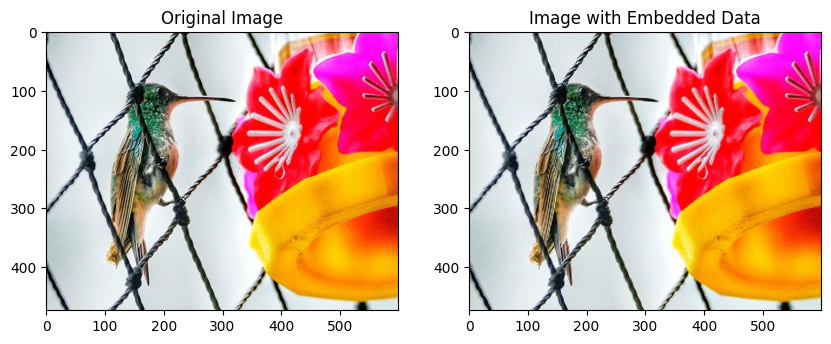

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

def compute_gradients(image):
    Kx = np.array([[-1, 1], [-1, 1]])  # 2D kernel for x-gradient
    Ky = np.array([[-1, -1], [1, 1]])  # 2D kernel for y-gradient
    Gx = convolve(image, Kx)
    Gy = convolve(image, Ky)
    return Gx, Gy

def compute_magnitude_and_angle(Gx, Gy):
    G = np.sqrt(Gx**2 + Gy**2)
    theta = np.arctan2(Gy, Gx) * 180 / np.pi  # Convert to degrees
    return G, theta

def normalize_magnitude(G):
    G_max = np.max(G)
    Gn = G / G_max if G_max != 0 else G
    return Gn

def quantize_angle(theta):
    angle_quantization = np.zeros_like(theta)
    theta = np.mod(theta + 180, 180)  # Normalize angles to [0, 180)
    angle_quantization[(theta >= 0) & (theta < 45)] = 1
    angle_quantization[(theta >= 45) & (theta < 90)] = 2
    angle_quantization[(theta >= 90) & (theta < 135)] = 3
    angle_quantization[(theta >= 135) & (theta < 180)] = 4
    return angle_quantization

def compute_hog(image, block_size=2):
    M, N = image.shape
    Gx, Gy = compute_gradients(image)
    G, theta = compute_magnitude_and_angle(Gx, Gy)
    Gn = normalize_magnitude(G)
    theta_q = quantize_angle(theta)

    # Ensure M and N are divisible by block_size
    M_pad = (block_size - M % block_size) % block_size
    N_pad = (block_size - N % block_size) % block_size
    Gn_padded = np.pad(Gn, ((0, M_pad), (0, N_pad)), mode='constant')
    theta_q_padded = np.pad(theta_q, ((0, M_pad), (0, N_pad)), mode='constant')

    M_padded, N_padded = Gn_padded.shape
    hog = np.zeros((M_padded // block_size, N_padded // block_size, 4))

    for i in range(0, M_padded, block_size):
        for j in range(0, N_padded, block_size):
            block_magnitude = Gn_padded[i:i+block_size, j:j+block_size]
            block_angle = theta_q_padded[i:i+block_size, j:j+block_size]
            for q in range(1, 5):
                hog[i // block_size, j // block_size, q - 1] = np.sum(block_magnitude[block_angle == q])
    return hog

def find_blocks_of_interest(hog, secret_message_length, increment=0.01):
    M, N, _ = hog.shape
    total_blocks = (M * N)  # Number of 2x2 blocks
    max_capacity = total_blocks * 4  # Each 2x2 block can store 4 bits
    max_capacity_bytes = max_capacity // 8
    print("M", M)
    print("N", N)
    print("max_capacity", max_capacity)
    if secret_message_length > max_capacity_bytes:
        raise ValueError(f"Secret message is too large to be embedded in the cover image. Maximum capacity is {max_capacity_bytes} bytes.")

    T = 0.1  # Starting with a higher initial threshold value
    while T <= 1.0:
        dominant_magnitude = np.max(hog, axis=2)
        BOI = dominant_magnitude > T
        Ne = np.sum(BOI)
        print(f"Threshold: {T:.2f}, Number of Edge Pixels: {Ne}")  # Debugging information
        if Ne >= secret_message_length:
            break
        T += increment
    return BOI, T

def clean_binary_file(file_path):
    with open(file_path, 'rb') as file:
        content = file.read()

    # Convert content to string and filter out anything that is not '0' or '1'
    cleaned_content = ''.join(chr(byte) for byte in content if chr(byte) in {'0', '1'})

    # Convert cleaned content back to bytes
    cleaned_bytes = bytearray(cleaned_content, 'utf-8')

    with open(file_path, 'wb') as file:
        file.write(cleaned_bytes)

def file_to_bit_string(file_path):
    clean_binary_file(file_path)
    with open(file_path, 'rb') as file:
        binary_data = file.read()
    return ''.join(format(byte, '08b') for byte in binary_data)

def bit_string_to_file(bit_string, output_path):
    byte_array = bytearray(int(bit_string[i:i+8], 2) for i in range(0, len(bit_string), 8))
    with open(output_path, 'wb') as file:
        file.write(byte_array)

def pvd_lsb_embed(image, BOI, bit_secret_data):
    data_index = 0
    data_length = len(bit_secret_data)

    embedded_image = image.copy()
    M, N = embedded_image.shape

    for i in range(0, M, 2):
        for j in range(0, N, 2):
            if i + 2 > M or j + 2 > N:
                continue  # Skip blocks that are out of bounds
            if BOI[i // 2, j // 2] and data_index < data_length:
                block = embedded_image[i:i+2, j:j+2].astype(np.int32)
                if data_index + 2 <= data_length:
                    p1, p2 = block[0, 1], block[1, 0]
                    diff = p2 - p1
                    secret_bits = bit_secret_data[data_index:data_index + 2]
                    secret_value = int(secret_bits, 2)
                    if diff < 0:
                        secret_value = -secret_value
                    new_p2 = np.clip(p1 + secret_value, 0, 255)
                    block[1, 0] = new_p2
                    data_index += 2
                for x in range(2):
                    for y in range(2):
                        if (x, y) != (0, 1) and (x, y) != (1, 0) and data_index < data_length:
                            pixel_value = block[x, y]
                            lsb_value = int(bit_secret_data[data_index])
                            block[x, y] = (pixel_value & ~1) | lsb_value
                            data_index += 1

                embedded_image[i:i+2, j:j+2] = block.astype(np.uint8)
                #print(f"Embedding at block ({i},{j}): {block.ravel()}")

    if data_index < data_length:
        print(f"Warning: Not all data was embedded. Data index: {data_index}, Data length: {data_length}")
    else:
        print(f"All data embedded successfully. Data index: {data_index}, Data length: {data_length}")

    return embedded_image

def pvd_lsb_extract(image, BOI, message_length):
    bit_data = []
    data_index = 0
    extracted_message_length = message_length * 8

    M, N = image.shape

    for i in range(0, M, 2):
        for j in range(0, N, 2):
            if i + 2 > M or j + 2 > N:
                continue  # Skip blocks that are out of bounds
            if BOI[i // 2, j // 2] and data_index < extracted_message_length:
                block = image[i:i+2, j:j+2].astype(np.int32)
                if data_index + 2 <= extracted_message_length:
                    p1, p2 = block[0, 1], block[1, 0]
                    diff = p2 - p1
                    secret_value = abs(diff)
                    secret_bits = format(secret_value, '02b')
                    bit_data.extend(secret_bits)
                    data_index += 2
                for x in range(2):
                    for y in range(2):
                        if (x, y) != (0, 1) and (x, y) != (1, 0) and data_index < extracted_message_length:
                            pixel_value = block[x, y]
                            lsb_value = pixel_value & 1
                            bit_data.append(str(lsb_value))
                            data_index += 1

                #print(f"Extracting at block ({i},{j}): {block.ravel()}")

    bit_string = ''.join(bit_data)

    if len(bit_string) < extracted_message_length:
        print(f"Warning: Extracted message is shorter than expected. Extracted length: {len(bit_string)}, Expected length: {extracted_message_length}")
    else:
        print(f"All data extracted successfully. Extracted length: {len(bit_string)}, Expected length: {extracted_message_length}")

    return bit_string[:message_length * 8]

def verify_data(file1, file2):
    with open(file1, 'rb') as f1, open(file2, 'rb') as f2:
        data1 = f1.read()
        data2 = f2.read()
    return data1 == data2

def compare_bit_strings(original, extracted):
    for i in range(len(original)):
        if original[i] != extracted[i]:
            print(f"Mismatch at position {i}: original={original[i]}, extracted={extracted[i]}")
            print(f"Original data surrounding mismatch: {original[i-10:i+10]}")
            print(f"Extracted data surrounding mismatch: {extracted[i-10:i+10]}")
            return False
    return True

def process_rgb_image(image, func, *args):
    channels = list(cv2.split(image))
    results = []
    for channel in channels:
        result = func(channel, *args)
        results.append(result)
    return results

# Example usage:

# Load an example image (RGB)
image_path = '3.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' could not be loaded. Please check the path and try again.")

# Read binary file and convert to bit string
bit_secret_data = file_to_bit_string('secret_file.bin')
secret_message_length = len(bit_secret_data) // 8

# Compute HOG and find BOI with adaptive thresholding for each channel
hogs = process_rgb_image(image, compute_hog)
BOIs = [find_blocks_of_interest(hog, secret_message_length)[0] for hog in hogs]

# Embed the bit secret data in each channel
embedded_image = image.copy()
channels = list(cv2.split(embedded_image))
for i, channel in enumerate(channels):
    BOI = BOIs[i]
    channel_embedded = pvd_lsb_embed(channel, BOI, bit_secret_data)
    channels[i] = channel_embedded
embedded_image = cv2.merge(channels)

# Extract the bit secret data from each channel
extracted_bit_strings = []
channels = list(cv2.split(embedded_image))
for i, channel in enumerate(channels):
    BOI = BOIs[i]
    extracted_bit_string = pvd_lsb_extract(channel, BOI, secret_message_length)
    extracted_bit_strings.append(extracted_bit_string)

# Combine extracted bit strings (if necessary)
# For simplicity, assuming the data is embedded in the first channel
extracted_bit_string = extracted_bit_strings[0]

bit_string_to_file(extracted_bit_string, 'extracted_secret_file.bin')

# Verify that the contents of the embedded data are the same as the extracted data
is_verified = verify_data('secret_file.bin', 'extracted_secret_file.bin')
print("Verification Result:", is_verified)

# Perform bit-by-bit comparison of the bit strings
comparison_result = compare_bit_strings(bit_secret_data, extracted_bit_string)
print("Bit String Comparison Result:", comparison_result)

# Display the original and embedded images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Image with Embedded Data")
plt.imshow(cv2.cvtColor(embedded_image, cv2.COLOR_BGR2RGB))

plt.show()
